<a href="https://colab.research.google.com/github/PCBZ/CS6140/blob/main/HW2B/HW2b_Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu

Loading wine dataset...

Training model...

Training time: 8.10 seconds

Train Accuracy: 100.00%
Test Accuracy: 100.00%


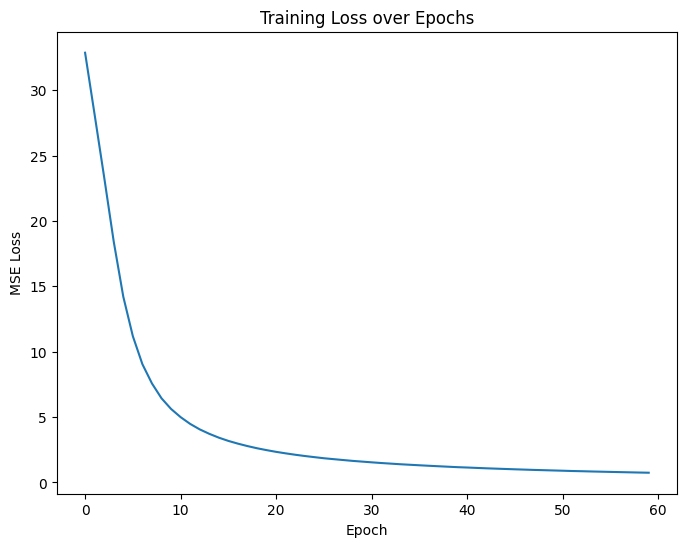

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import time

class PyTorchWineClassifierNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 0.1):
        super(PyTorchWineClassifierNN, self).__init__()

        # Define layers
        self.hidden = nn.Linear(input_size, hidden_size)
        self.sigmoid1 = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid2 = nn.Sigmoid()

        # Initialize optimizer and loss function
        self.learning_rate = learning_rate
        self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # Forward pass
        out = self.hidden(x)
        out = self.sigmoid1(out)
        out = self.output(out)
        out = self.sigmoid2(out)
        return out

    def train_model(self, train_loader, epoches = 1000, device = "cpu"):
        """
        Train the neural network model.
        """
        self.train()
        loss_history = []

        start_time = time.time()

        for epoch in range(epoches):

            epoch_loss = 0.0
            num_batches = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.to(device)
                target = target.to(device)

                # Forward pass
                output = self(data)
                loss = self.criterion(output, target)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1

            # Calculate average loss for the epoch
            avg_loss = epoch_loss / num_batches
            loss_history.append(epoch_loss)

        end_time = time.time()
        self.training_time = end_time - start_time

        return loss_history

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            outputs = self(X)
            _, predicted = torch.max(outputs, 1)
        return predicted

def load_wine_data():
    train_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/train_wine.csv"
    test_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/test_wine.csv"

    # Load data
    train_data = pd.read_csv(train_url, header=None)
    test_data = pd.read_csv(test_url, header=None)

    # Separate features and labels
    X_train = train_data.iloc[:, 1:].values  # Features are columns 1-13
    y_train = train_data.iloc[:, 0].values   # Labels are column 0

    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values

    unique_labels = np.unique(y_train)

    if unique_labels.min() > 0:
        y_train = y_train - 1
        y_test = y_test - 1

    return X_train, y_train, X_test, y_test

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get predicts
            predicted = model.predict(inputs)

            if len(labels.shape) > 1:
                _, labels = torch.max(labels, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

def main():
    # Check device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load data
    print("\nLoading wine dataset...")
    X_train, y_train, X_test, y_test = load_wine_data()

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)

    # One-hot encode
    y_train_onehot = np.zeros((y_train.shape[0], 3))
    y_train_onehot[np.arange(y_train.shape[0]), y_train.astype(int)] = 1
    y_test_onehot = np.zeros((y_test.shape[0], 3))
    y_test_onehot[np.arange(y_test.shape[0]), y_test.astype(int)] = 1

    y_train = torch.FloatTensor(y_train_onehot)
    y_test = torch.FloatTensor(y_test_onehot)

    # Create dataset and data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 1
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

    # Set hyperparameters
    input_size = 13
    hidden_size = 10
    output_size = 3
    learning_rate = 0.1
    epochs = 60

    # Initialize model
    model = PyTorchWineClassifierNN(input_size, hidden_size, output_size, learning_rate).to(device)

    # Train model
    print("\nTraining model...")
    loss_history = model.train_model(train_loader, epochs, device)

    print(f"\nTraining time: {model.training_time:.2f} seconds")

    # Evaluation
    train_accuracy = evaluate(model, train_loader, device)
    test_accuracy = evaluate(model, test_loader, device)

    print(f"\nTrain Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Plot training loss
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history)
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.show()

if __name__ == "__main__":
    main()
